In [2]:
import pandas as pd
import geopandas as gpd

# === 1. Excel-Datei einlesen ===
excel_path = "Input/Biggest_Cities_Bavaria.xlsx"
df = pd.read_excel(excel_path, dtype=str)  # alle Spalten als Strings laden

# Spaltennamen säubern und sicherstellen, dass relevante Felder korrekt benannt sind
df.columns = df.columns.str.strip()
df = df.rename(columns={
    "ARS": "ARS",
    "Name": "Name",
    "Einwohner": "Einwohner"
})

# Einwohner in Integer umwandeln
df["Einwohner"] = df["Einwohner"].astype(int)

# Top 50 Städte nach Einwohnerzahl auswählen
df = df.sort_values(by="Einwohner", ascending=False).head(50)

# === 2. ARS-Spalte normalisieren ===
# Ziel: 8-stellig mit führender Null + 4 Nullen → 12-stellig wie in Shapefile
df["ARS"] = df["ARS"].str.zfill(8) + "0000"

# Falls versehentlich zu lang: auf 12 Stellen kürzen
df["ARS"] = df["ARS"].str[:12]

# === 3. Shapefile einlesen und Bayern filtern ===
shapefile_path = "Input/VG250_GEM.shp"
gdf = gpd.read_file(shapefile_path)

# ARS als String behandeln und auf 12 Stellen beschränken
gdf["ARS"] = gdf["ARS"].astype(str).str.strip()
gdf_bayern = gdf[gdf["ARS"].str.startswith("09")]

# === 4. Merge durchführen ===
merged = gdf_bayern.merge(df, on="ARS")

print(f"✅ {len(merged)} von 50 Städte erfolgreich gemerged.")

# === 5. Neue Shapefile exportieren ===
output_path = "top50_bayern_staedte.shp"
merged.to_file(output_path)

print("🎉 Shapefile erfolgreich gespeichert unter:", output_path)


✅ 50 von 50 Städte erfolgreich gemerged.
🎉 Shapefile erfolgreich gespeichert unter: top50_bayern_staedte.shp


/Users/johnfriesen/Documents/GitHub/Temperature_Comparison/myenv/lib/python3.9/site-packages/pyogrio/raw.py:723: RuntimeWarning: Field BEGINN create as date field, though DateTime requested.
  ogr_write(
/Users/johnfriesen/Documents/GitHub/Temperature_Comparison/myenv/lib/python3.9/site-packages/pyogrio/raw.py:723: RuntimeWarning: Field WSK create as date field, though DateTime requested.
  ogr_write(
/Users/johnfriesen/Documents/GitHub/Temperature_Comparison/myenv/lib/python3.9/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Unnamed: 2' to 'Unnamed_ 2'
  ogr_write(


In [3]:
import pandas as pd
from pathlib import Path

# -------------------------------------------------------------------------
# 1.  LOAD  –– choose ONE of the two options
# -------------------------------------------------------------------------
# (a) from disk …
df = pd.read_csv(Path("Input/city_metrics.csv"))

# (b) … or, if your CSV is already in a Python string variable `raw`:
# from io import StringIO
# df = pd.read_csv(StringIO(raw))

# -------------------------------------------------------------------------
# 2.  HOUSE-KEEPING
# -------------------------------------------------------------------------
df["sensor"] = df["sensor"].str.strip().str.upper()        # e.g. 'LANDSAT_8' → 'LANDSAT_8'
df["date"]   = pd.to_datetime(df["date"]).dt.normalize()   # strips any time component

# split the frame once so we preserve all original columns for later inspection
modis    = df[df["sensor"].str.contains(r"\bMODIS\b",    regex=True)].copy()
landsat  = df[df["sensor"].str.contains(r"\bLANDSAT\b",  regex=True)].copy()

# keep ONLY the date column in the two 'key' frames we will merge on
modis_key   = modis[["date"]].rename(columns={"date": "modis_date"}).drop_duplicates()
landsat_key = landsat[["date"]].rename(columns={"date": "landsat_date"}).drop_duplicates()

# -------------------------------------------------------------------------
# 3.  CROSS-JOIN + FILTER BY ≤ 3 DAYS
# -------------------------------------------------------------------------
# create a dummy 'key' so pandas gives us the Cartesian product
modis_key["k"]   = 1
landsat_key["k"] = 1

pairs = (modis_key
         .merge(landsat_key, on="k", how="inner")
         .drop("k", axis=1))

pairs["diff_days"] = (pairs["modis_date"] - pairs["landsat_date"]).abs().dt.days
close_pairs = pairs.query("diff_days <= 2").sort_values(["modis_date", "diff_days"])

# -------------------------------------------------------------------------
# 4.  DISPLAY / SAVE / USE THE RESULT
# -------------------------------------------------------------------------
if close_pairs.empty:
    print("⚠️  No Landsat/MODIS observations lie within ±3 days of each other.")
else:
    print("Landsat vs. MODIS dates that are ≤ 3 days apart:")
    print(close_pairs.to_string(index=False))

    # (optional) keep the FULL rows for those dates:
    overlap_dates = pd.unique(close_pairs[["modis_date", "landsat_date"]].values.ravel("K"))
    df_3day_window = df[df["date"].isin(overlap_dates)]

    # df_3day_window now holds every original record that participates in at
    # least one ≤ 3-day Landsat/MODIS pairing – handy for plotting or export.


Landsat vs. MODIS dates that are ≤ 3 days apart:
modis_date landsat_date  diff_days
2024-01-09   2024-01-11          2
2024-01-25   2024-01-27          2
2024-02-26   2024-02-28          2
2024-03-29   2024-03-31          2
2024-04-30   2024-05-02          2
2024-08-04   2024-08-06          2
2024-09-05   2024-09-07          2



Bad key mpl_toolkits.legacy_colorbar in file FST.mplstyle, line 757 ('mpl_toolkits.legacy_colorbar: True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.9.4/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_15849/328823932.py:6: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring this parameter.
  plt.style.use("FST.mplstyle")
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_15849/328823932.py:6: UserWarning: Style includes a parameter, 'backend_fallback', that is not related to style.  Ignoring this parameter.
  plt.style.use("FST.mplstyle")
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_15849/328823932.py:6: UserWarning: Style includes a parameter, 'date.epoch', that is not related to style.  Ignoring this parameter.
  plt.style.use("FST.mplstyle")
/var/folders/p0/6j2q4pb14

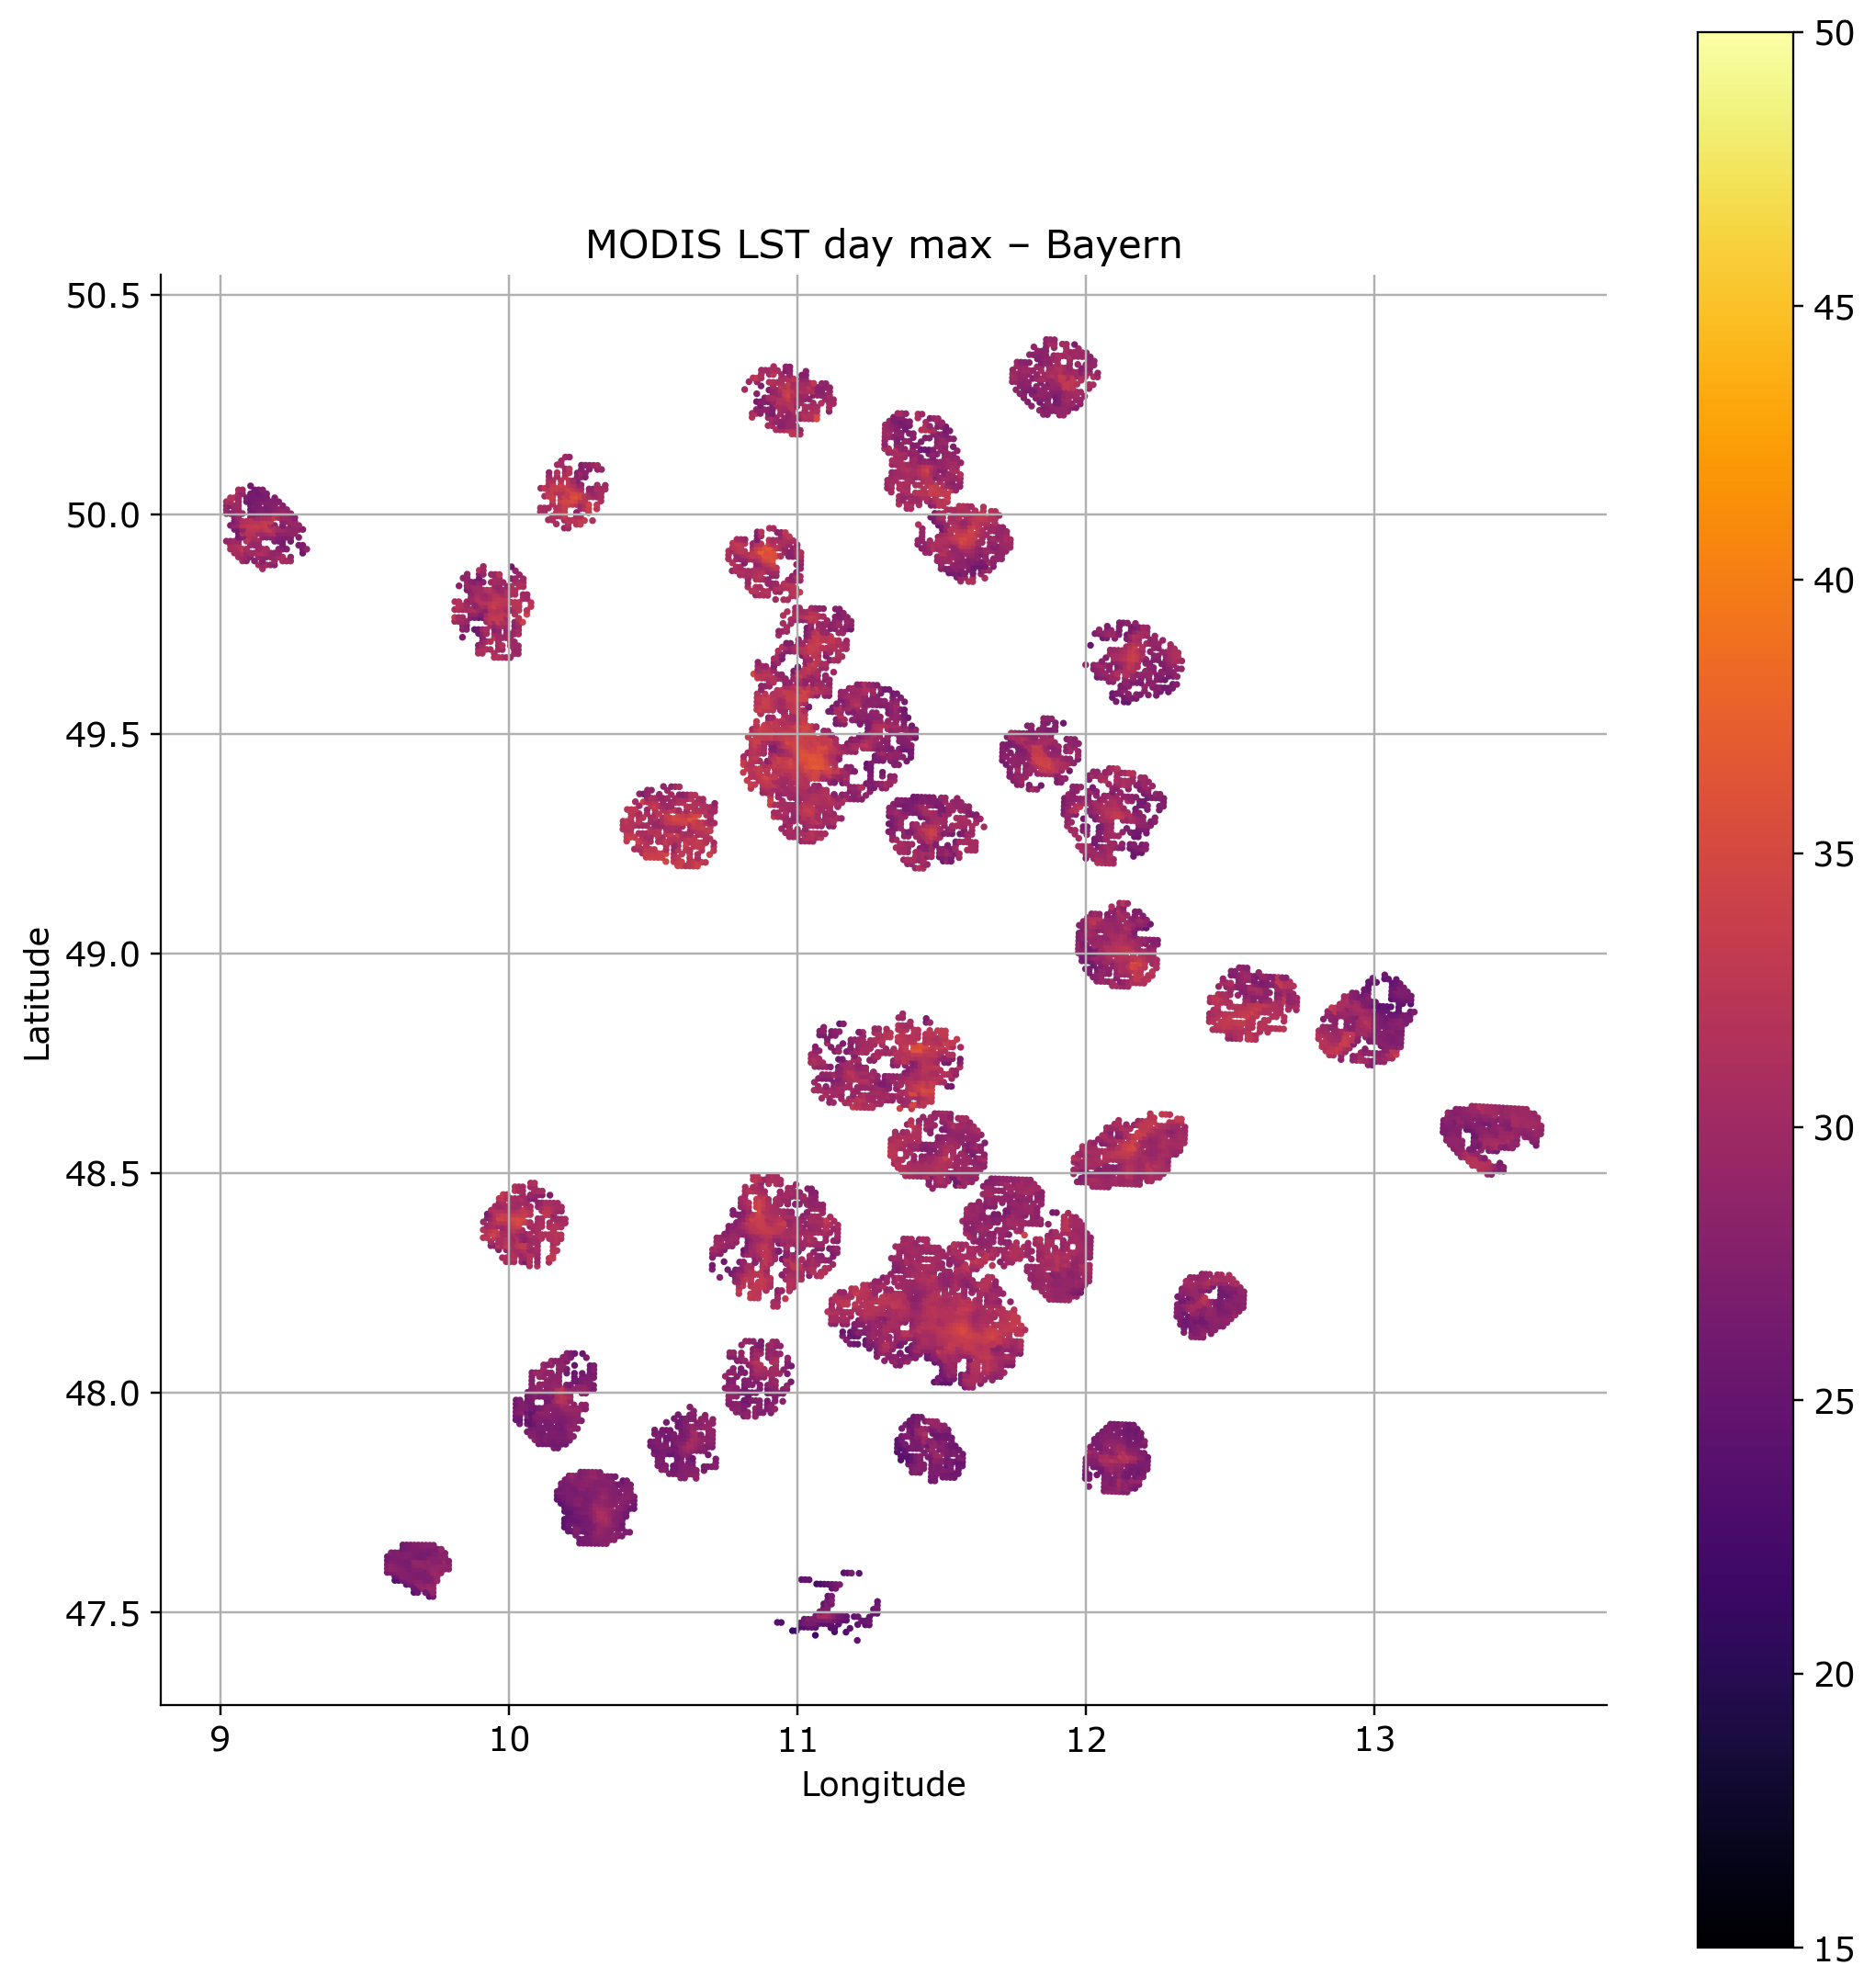

In [5]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

plt.style.use("FST.mplstyle")


# === 1. CSV laden ===
csv_path = "Input/LST_all_NDVI_Landcover_Modis_Bayern.csv"
df = pd.read_csv(csv_path)

# === 2. Nur gültige Koordinaten behalten ===
df = df.dropna(subset=["Latitude", "Longitude"])
df["Latitude"] = df["Latitude"].astype(float)
df["Longitude"] = df["Longitude"].astype(float)

# === 3. GeoDataFrame erzeugen ===
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["Longitude"], df["Latitude"]),
    crs="EPSG:4326"  # WGS84
)

# === 4. Plotten (z. B. nach LST_day_Mean einfärben) ===
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(
    column="LST_day_Max",
    cmap="inferno",         # Wärmeskala
    legend=True,
    vmin=15,               # Untere Grenze der Farbskala
    vmax=50, 
    ax=ax,
    markersize=2,
    missing_kwds={"color": "lightgrey", "label": "Kein Wert"}
)

plt.title("MODIS LST day max – Bayern", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.show()



In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

plt.style.use("FST.mplstyle")

# === 1. Daten einlesen ===
stations_df = pd.read_csv("Input/city_metrics.csv")
pixels_df = pd.read_csv("Input/LST_all_NDVI_Landcover_Modis_Bayern.csv")

# === 2. Nur MODIS + Sommerdaten verwenden ===
stations_df = stations_df[
    (stations_df["season"] == "Summer") &
    (stations_df["sensor"] == "MODIS")
]

# === 3. Ausgabeordner für Plots anlegen ===
output_dir = "plots_by_city"
os.makedirs(output_dir, exist_ok=True)

# === 4. Städte aus Pixel-Daten verwenden (besserer Referenzpunkt) ===
unique_cities = pixels_df["City"].dropna().unique()

# === 5. Schleife über alle Städte ===
for stadt in unique_cities:
    # Stationsdaten mit passendem Stadtnamen (Teilstring-Suche)
    station_data = stations_df[stations_df["Name"].str.contains(stadt, case=False, na=False)]
    stadt_pixel_data = pixels_df[pixels_df["City"].str.contains(stadt, case=False, na=False)]

    # Falls keine Daten vorhanden, überspringen
    if station_data.empty or stadt_pixel_data.empty:
        print(f"⚠️ Überspringe {stadt} – keine passenden Daten gefunden")
        continue

    # === 6. Stationsstatistiken berechnen ===
    station_stats = {
        "TXK_mean": station_data["TXK"].mean(),
        "LST_day_Max": station_data["LST"].max(),
        "LST_day_Mean": station_data["LST"].mean()
    }

    print(f"\n📍 Stadt: {stadt}")
    for k, v in station_stats.items():
        print(f"  {k}: {v:.2f} °C")

    # === 7. Boxplots erstellen ===
    plt.figure(figsize=(12, 5))
    vars_to_plot = ["LST_day_Max", "LST_day_Mean"]

    for i, var in enumerate(vars_to_plot):
        plt.subplot(1, 2, i + 1)

        sns.boxplot(y=stadt_pixel_data[var])

        # MODIS-Wert (rot)
        plt.scatter(0, station_stats[var], color='red', zorder=10, label='MODIS (Wetterstation)')

        # TXK-Wert (blau)
        plt.scatter(0, station_stats["TXK_mean"], color='blue', zorder=11, label='TXK (Wetterstation)')

        plt.title(f"{stadt} – {var}")
        plt.ylabel("°C")
        plt.xticks([])
        if i == 0:
            plt.legend()

    plt.suptitle(f"{stadt}: LST-Verteilung vs. Wetterstation (Sommer, MODIS & TXK)", fontsize=13)
    plt.tight_layout()

    # Plot speichern
    filename = f"{stadt.replace(' ', '_')}_vergleich.png"
    plt.savefig(os.path.join(output_dir, filename), dpi=150)
    plt.close()



Bad key mpl_toolkits.legacy_colorbar in file FST.mplstyle, line 757 ('mpl_toolkits.legacy_colorbar: True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.9.4/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_15849/3864082804.py:6: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring this parameter.
  plt.style.use("FST.mplstyle")
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_15849/3864082804.py:6: UserWarning: Style includes a parameter, 'backend_fallback', that is not related to style.  Ignoring this parameter.
  plt.style.use("FST.mplstyle")
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_15849/3864082804.py:6: UserWarning: Style includes a parameter, 'date.epoch', that is not related to style.  Ignoring this parameter.
  plt.style.use("FST.mplstyle")
/var/folders/p0/6j2q4p

⚠️ Überspringe Ingolstadt – keine passenden Daten gefunden

📍 Stadt: München
  TXK_mean: 25.16 °C
  LST_day_Max: 32.43 °C
  LST_day_Mean: 28.21 °C
⚠️ Überspringe Rosenheim – keine passenden Daten gefunden

📍 Stadt: Landshut
  TXK_mean: 25.38 °C
  LST_day_Max: 29.29 °C
  LST_day_Mean: 24.73 °C
⚠️ Überspringe Passau – keine passenden Daten gefunden

📍 Stadt: Straubing
  TXK_mean: 26.79 °C
  LST_day_Max: 32.29 °C
  LST_day_Mean: 27.52 °C

📍 Stadt: Amberg
  TXK_mean: 26.36 °C
  LST_day_Max: 33.21 °C
  LST_day_Mean: 27.89 °C

📍 Stadt: Regensburg
  TXK_mean: 27.16 °C
  LST_day_Max: 31.01 °C
  LST_day_Mean: 27.96 °C
⚠️ Überspringe Weiden i.d. OPf. – keine passenden Daten gefunden

📍 Stadt: Bamberg
  TXK_mean: 26.05 °C
  LST_day_Max: 33.21 °C
  LST_day_Mean: 28.16 °C
⚠️ Überspringe Bayreuth – keine passenden Daten gefunden
⚠️ Überspringe Coburg – keine passenden Daten gefunden

📍 Stadt: Hof
  TXK_mean: 24.50 °C
  LST_day_Max: 29.97 °C
  LST_day_Mean: 25.50 °C
⚠️ Überspringe Ansbach – keine pas

/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_15849/3864082804.py:28: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  station_data = stations_df[stations_df["Name"].str.contains(stadt, case=False, na=False)]
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_15849/3864082804.py:29: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  stadt_pixel_data = pixels_df[pixels_df["City"].str.contains(stadt, case=False, na=False)]


⚠️ Überspringe Geretsried – keine passenden Daten gefunden
⚠️ Überspringe Dachau – keine passenden Daten gefunden
⚠️ Überspringe Erding – keine passenden Daten gefunden
⚠️ Überspringe Freising – keine passenden Daten gefunden
⚠️ Überspringe Fürstenfeldbruck – keine passenden Daten gefunden
⚠️ Überspringe Germering – keine passenden Daten gefunden
⚠️ Überspringe Olching – keine passenden Daten gefunden
⚠️ Überspringe Landsberg am Lech – keine passenden Daten gefunden
⚠️ Überspringe Waldkraiburg – keine passenden Daten gefunden
⚠️ Überspringe Unterschleißheim – keine passenden Daten gefunden
⚠️ Überspringe Neuburg a.d. Donau – keine passenden Daten gefunden
⚠️ Überspringe Pfaffenhofen a.d. Ilm – keine passenden Daten gefunden
⚠️ Überspringe Deggendorf – keine passenden Daten gefunden
⚠️ Überspringe Neumarkt i.d. OPf. – keine passenden Daten gefunden

📍 Stadt: Schwandorf
  TXK_mean: 26.93 °C
  LST_day_Max: 31.63 °C
  LST_day_Mean: 27.02 °C
⚠️ Überspringe Forchheim – keine passenden Daten 

/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_15849/3864082804.py:28: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  station_data = stations_df[stations_df["Name"].str.contains(stadt, case=False, na=False)]
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_15849/3864082804.py:29: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  stadt_pixel_data = pixels_df[pixels_df["City"].str.contains(stadt, case=False, na=False)]



Bad key mpl_toolkits.legacy_colorbar in file FST.mplstyle, line 757 ('mpl_toolkits.legacy_colorbar: True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.9.4/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_15849/2642796254.py:6: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring this parameter.
  plt.style.use("FST.mplstyle")
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_15849/2642796254.py:6: UserWarning: Style includes a parameter, 'backend_fallback', that is not related to style.  Ignoring this parameter.
  plt.style.use("FST.mplstyle")
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_15849/2642796254.py:6: UserWarning: Style includes a parameter, 'date.epoch', that is not related to style.  Ignoring this parameter.
  plt.style.use("FST.mplstyle")
/var/folders/p0/6j2q4p

Index(['system:index', 'Buffer_Indicator', 'City', 'LC_1_Frac', 'LC_2_Frac',
       'LC_3_Frac', 'LC_4_Frac', 'LC_5_Frac', 'LC_6_Frac', 'LC_7_Frac',
       'LC_8_Frac', 'LST_day_Max', 'LST_day_Mean', 'LST_day_Median',
       'LST_day_Std', 'LST_night_Max', 'LST_night_Mean', 'LST_night_Median',
       'LST_night_Std', 'Latitude', 'Longitude', 'NDVI_Max', 'NDVI_Mean',
       'NDVI_Median', 'NDVI_Std', 'Zensus', '.geo'],
      dtype='object')
            Stadt  Einwohner  Pixelanzahl    CV  Delta_UHI  MODIS_geeignet
          München    1478638          298 0.046       1.72            True
         Nürnberg     522554          163 0.066       2.13            True
         Augsburg     294647          107 0.076       1.59            True
       Regensburg     145901           72 0.046       2.25            True
       Ingolstadt     136468          103 0.074       0.57            True
         Würzburg     131316           75 0.057       1.23            True
            Fürth     130126   

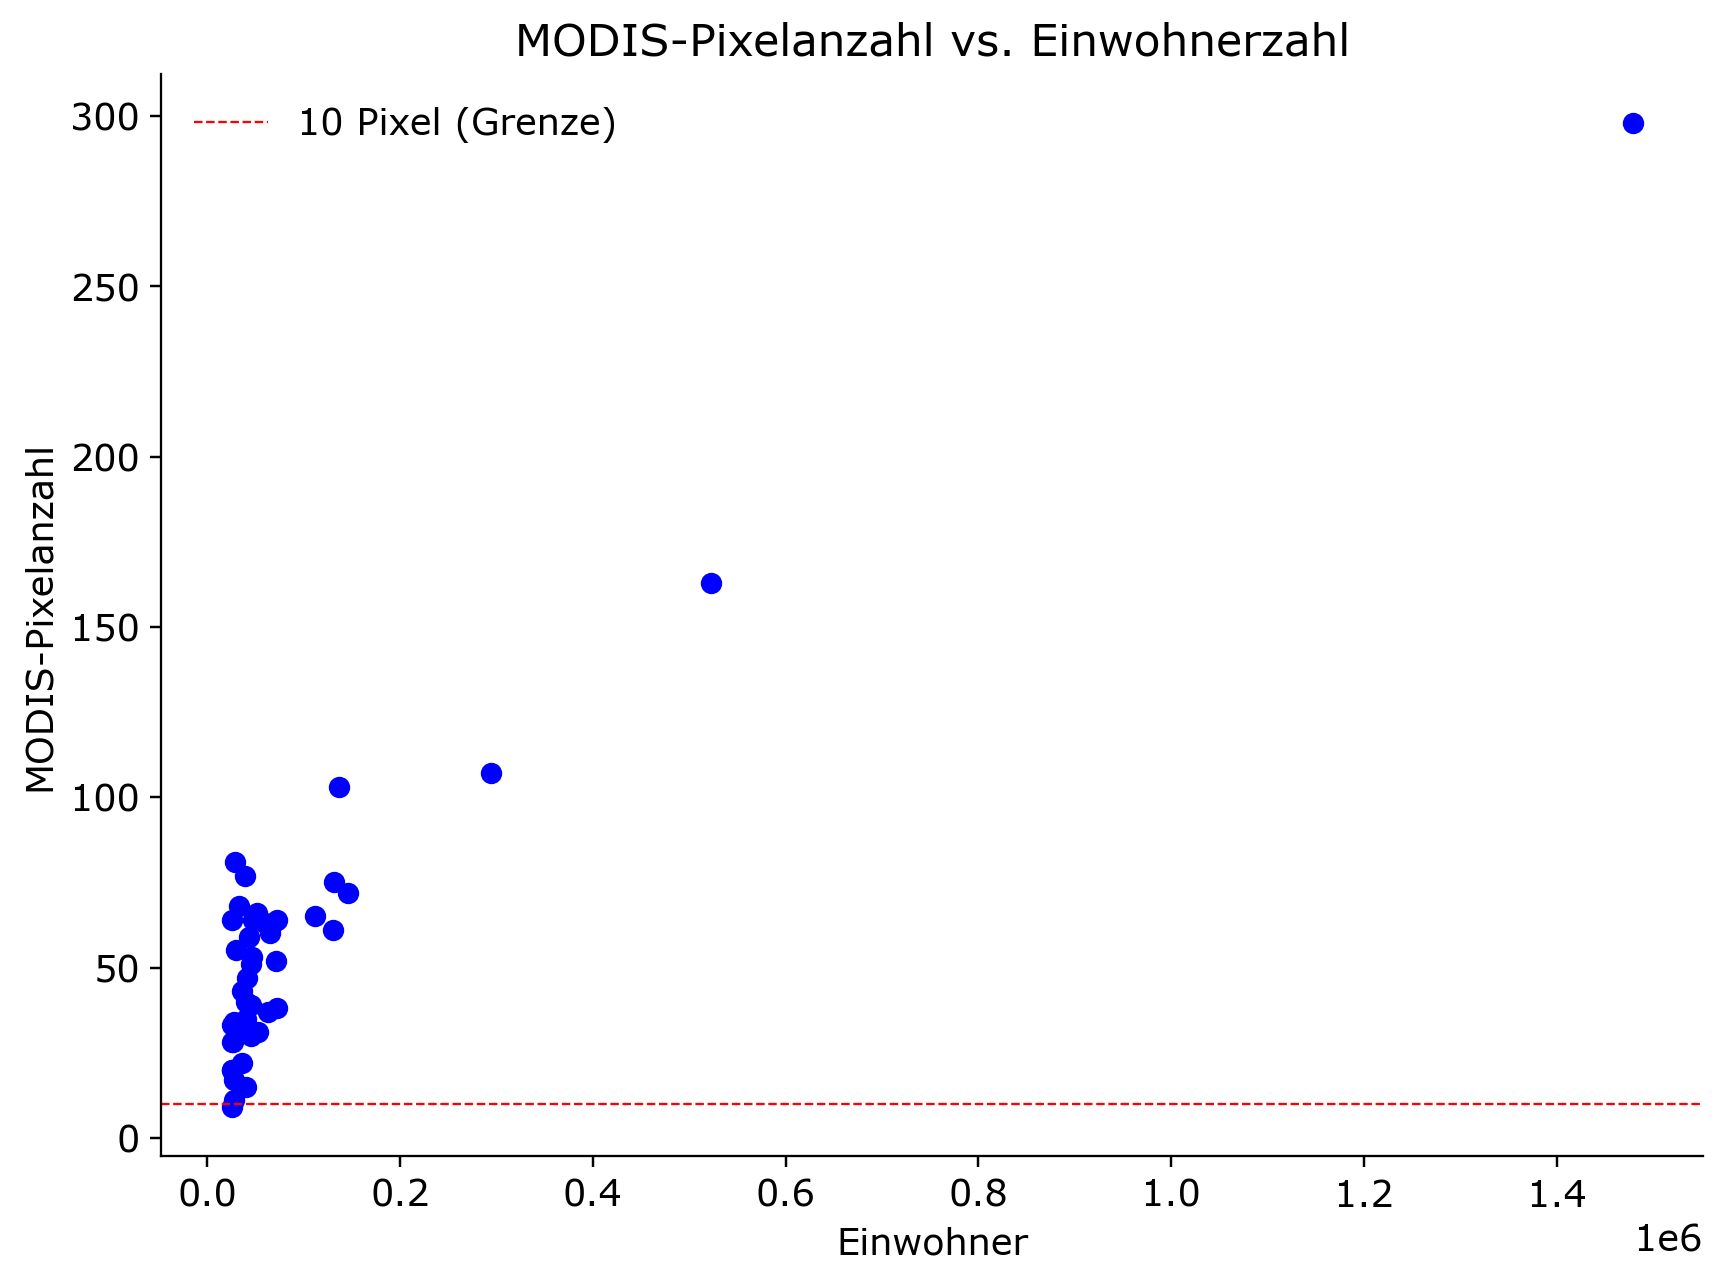

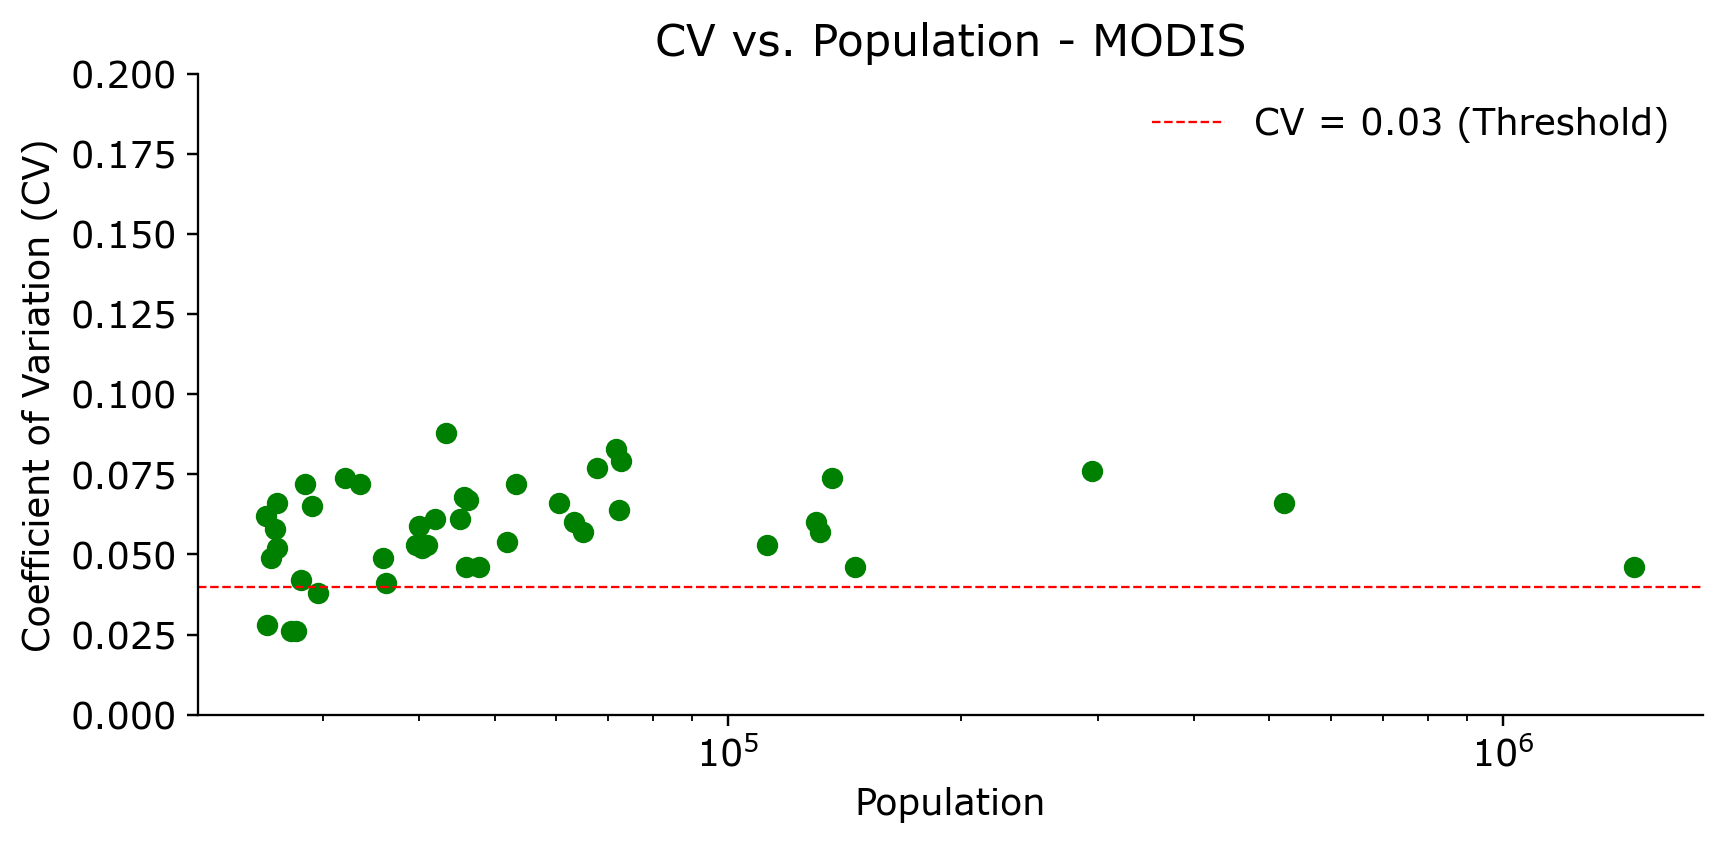

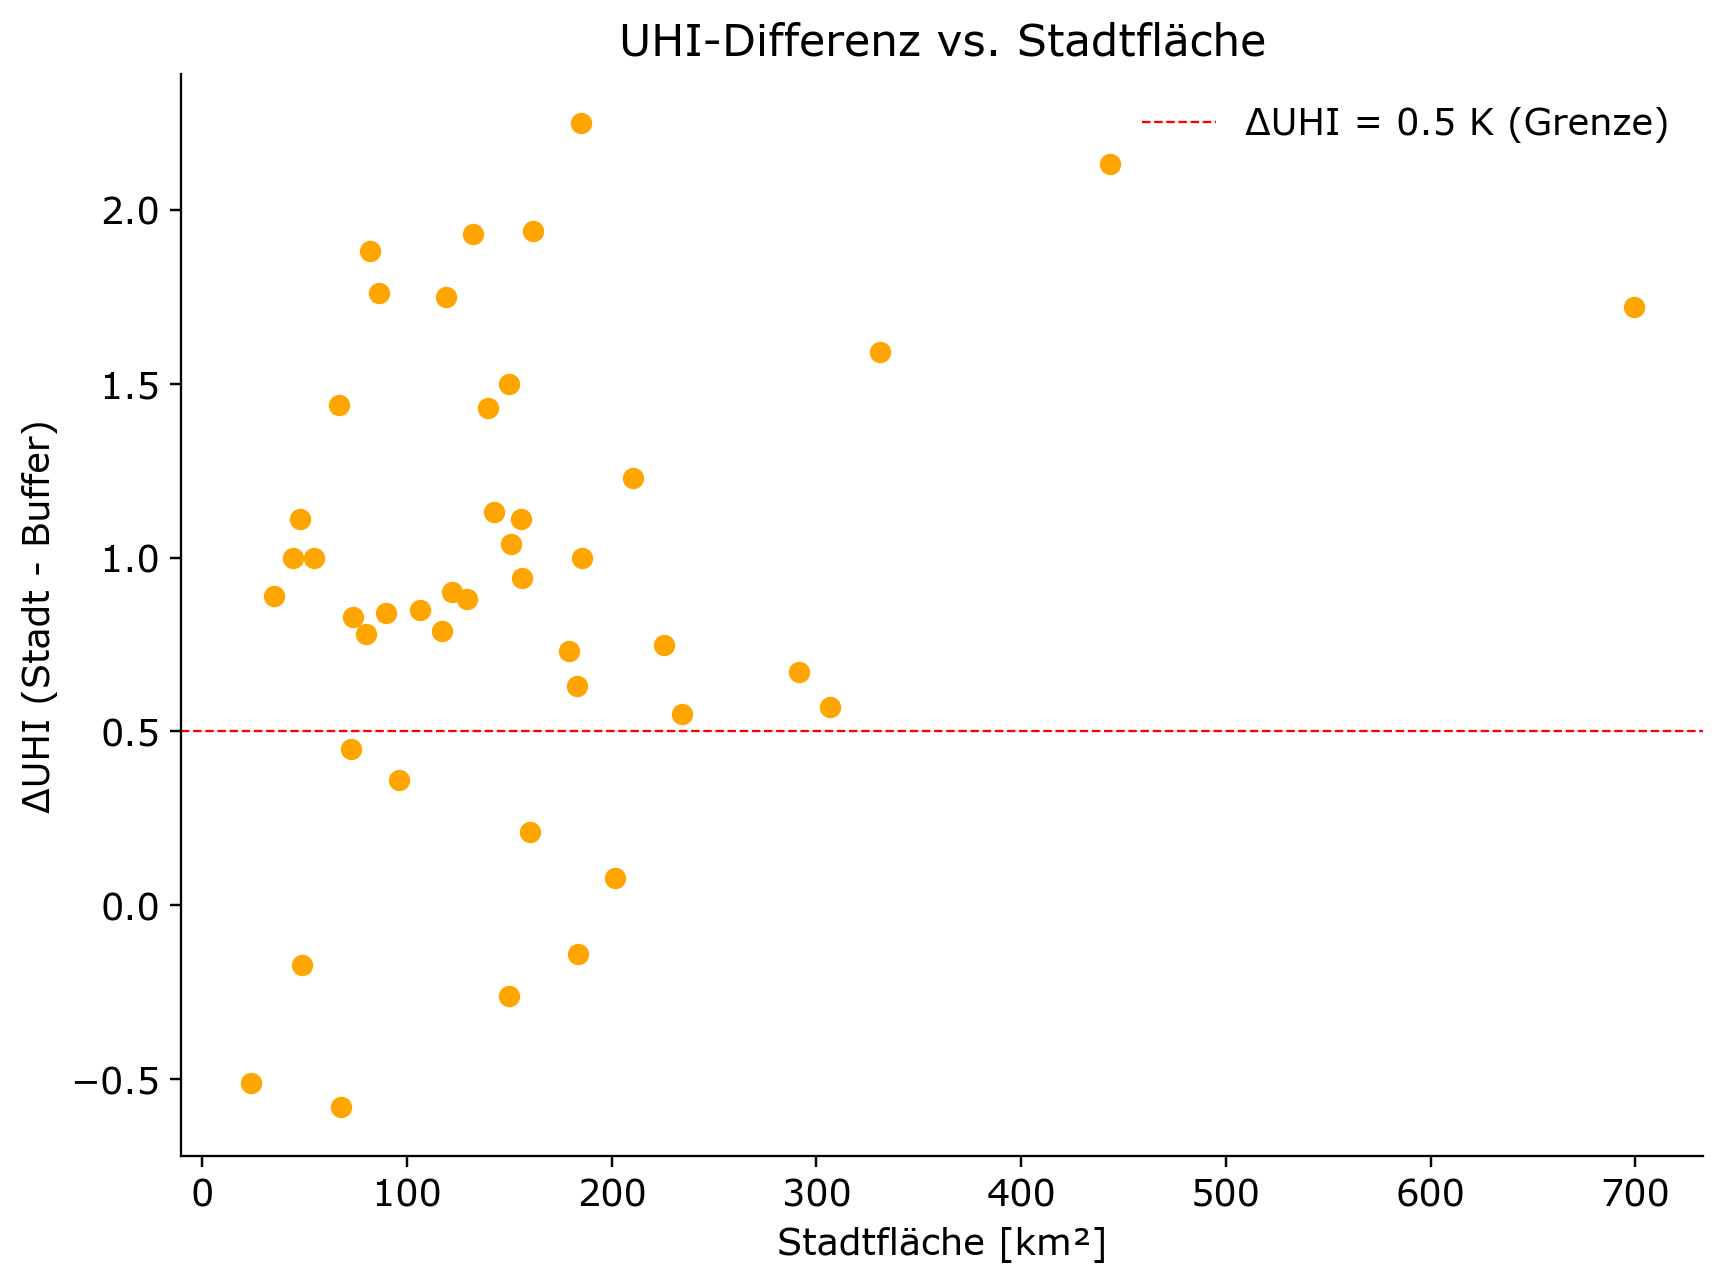

LinregressResult(slope=np.float64(-2.5075994041433945e-09), intercept=np.float64(0.05852747498008493), rvalue=np.float64(-0.03955789767185162), pvalue=np.float64(0.7987670039749402), stderr=np.float64(9.773727942317999e-09), intercept_stderr=np.float64(0.002423335658978263))

In [8]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import matplotlib.pyplot as plt
plt.style.use("FST.mplstyle")

# === 1. Daten laden ===
gdf_cities = gpd.read_file("Input/top50_bayern_staedte.shp").to_crs("EPSG:4326")

df_modis = pd.read_csv("Input/LST_all_NDVI_Landcover_Modis_Bayern.csv")
print(df_modis.columns)
df_modis = df_modis.dropna(subset=["Latitude", "Longitude", "LST_day_Mean", "Buffer_Indicator", "City"])

# GeoDataFrame aus MODIS-Daten
gdf_modis = gpd.GeoDataFrame(
    df_modis,
    geometry=gpd.points_from_xy(df_modis["Longitude"], df_modis["Latitude"]),
    crs="EPSG:4326"
)

# === 2. Stadtfläche berechnen (für Pixeldichte) ===
gdf_cities_metric = gdf_cities.to_crs(epsg=3857)
gdf_cities["Stadtfläche_km2"] = gdf_cities_metric.area / 1e6

# === 3. Analyse pro Stadt ===
results = []

for _, city in gdf_cities.iterrows():
    name = city["Name"]
    einwohner = city["Einwohner"]
    flaeche_km2 = city["Stadtfläche_km2"]

    # Stadtpixel (Buffer == 0)
    urban_pixels = gdf_modis[
        (gdf_modis["City"].str.lower() == name.lower()) & (gdf_modis["Buffer_Indicator"] == 0)
    ]
    pixel_count = len(urban_pixels)

    if pixel_count == 0:
        continue

    lst_mean = urban_pixels["LST_day_Mean"].mean()
    lst_std = urban_pixels["LST_day_Mean"].std()
    cv = lst_std / lst_mean if lst_mean else 0
    snr = abs(lst_mean) / 0.5
    pixeldichte = pixel_count / flaeche_km2 if flaeche_km2 else 0

    # Pufferpixel (Buffer == 1)
    rural_pixels = gdf_modis[
        (gdf_modis["City"].str.lower() == name.lower()) & (gdf_modis["Buffer_Indicator"] == 1)
    ]
    delta_uhi = None
    if not rural_pixels.empty:
        rural_mean = rural_pixels["LST_day_Mean"].mean()
        delta_uhi = lst_mean - rural_mean

    results.append({
        "Stadt": name,
        "Einwohner": einwohner,
        "Stadtfläche_km2": round(flaeche_km2, 2),
        "Pixelanzahl": pixel_count,
        "Pixeldichte": round(pixeldichte, 2),
        "LST_Mean": round(lst_mean, 2),
        "LST_Std": round(lst_std, 2),
        "CV": round(cv, 3),
        "SNR": round(snr, 2),
        "Delta_UHI": round(delta_uhi, 2) if delta_uhi is not None else None,
        "MODIS_geeignet": (
            pixel_count >= 10 and
            cv >= 0.03 and
            delta_uhi is not None and
            delta_uhi >= 0.5
        )
    })

df_results = pd.DataFrame(results)
df_results = df_results.sort_values("Einwohner", ascending=False)

# === 4. Ergebnisse anzeigen und speichern ===
print(df_results[["Stadt", "Einwohner", "Pixelanzahl", "CV", "Delta_UHI", "MODIS_geeignet"]].to_string(index=False))

# === 5. Plots erzeugen & speichern ===
plt.style.use("FST.mplstyle")
fig_dir = "modis_plots"
os.makedirs(fig_dir, exist_ok=True)

# Plot 1: Pixelanzahl vs. Einwohner
plt.figure(figsize=(8, 6))
plt.scatter(df_results["Einwohner"], df_results["Pixelanzahl"], c="blue")
plt.axhline(10, color="red", linestyle="--", label="10 Pixel (Grenze)")
plt.xlabel("Einwohner")
plt.ylabel("MODIS-Pixelanzahl")
plt.title("MODIS-Pixelanzahl vs. Einwohnerzahl")
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: CV vs. Einwohner
plt.figure(figsize=(8, 4))
plt.scatter(df_results["Einwohner"], df_results["CV"], c="green")
plt.axhline(0.04, color="red", linestyle="--", label="CV = 0.03 (Threshold)")
plt.xlabel("Population")
plt.ylabel("Coefficient of Variation (CV)")
plt.title("CV vs. Population - MODIS")
plt.ylim([0,0.2])
plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.show()

# Plot 3: ΔUHI vs. Stadtfläche
plt.figure(figsize=(8, 6))
plt.scatter(df_results["Stadtfläche_km2"], df_results["Delta_UHI"], c="orange")
plt.axhline(0.5, color="red", linestyle="--", label="ΔUHI = 0.5 K (Grenze)")
plt.xlabel("Stadtfläche [km²]")
plt.ylabel("ΔUHI (Stadt - Buffer)")
plt.title("UHI-Differenz vs. Stadtfläche")
plt.legend()
plt.tight_layout()
plt.show()

from scipy.stats import linregress

linregress(df_results["Einwohner"], df_results["CV"])
